In [1]:
import pandas as pd
import numpy as np
import os
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import glob
from scipy.signal import detrend, get_window
from scipy.signal import butter, filtfilt
from scipy.fftpack import fft, fftfreq
from scipy.signal import hilbert, chirp

In [2]:
def compute_skewness(x):
    
    n = len(x)
    third_moment = np.sum((x - np.mean(x))**3) / n
    s_3 = np.std(x, ddof = 1) ** 3
    return third_moment/s_3

In [3]:
def compute_kurtosis(x):
    
    n = len(x)
    fourth_moment = np.sum((x - np.mean(x))**4) / n
    s_4 = np.std(x, ddof = 1) ** 4
    return fourth_moment / s_4 - 3

In [4]:
def to_feature(df):
    data = pd.DataFrame()
    data['max'] = df[df.columns[:]].max(axis = 1)
    data['min'] = df[df.columns[:]].min(axis = 1)
    data['mean'] = df[df.columns[:]].mean(axis = 1)
    data['std'] = df[df.columns[:]].std(ddof=1,axis = 1)
    data['rms'] = df[df.columns[:]].apply(lambda x: np.sqrt(np.mean(x**2)), axis=1)
    data['skewness'] = df[df.columns[:]].apply(lambda x: compute_skewness(x), axis=1)
    data['kurtosis'] = df[df.columns[:]].apply(lambda x: compute_kurtosis(x), axis=1)
    data['crest_factor'] = data['max'] / data['rms']
    data['form_factor'] = data['rms'] / data['mean']
    return data

In [5]:
def to_freq(df_time:pd.DataFrame):
    df_freq = df_time.copy()
    filter_vibr = pd.RangeIndex(start=0, stop=len(df_freq.columns), step=1)
    df_freq = df_freq.drop(columns=filter_vibr, axis = 1)
    
    freq_data = []
    for i,row in df_time.iterrows():
        y = np.array(df_time.loc[i,:])
        # vibration_data = data['Vibration'].values
        vibration_data = y
        # Time parameters
        sampling_rate =  len(vibration_data) # Hz, example sampling rate
        n = len(vibration_data)
        time = np.arange(n) / sampling_rate

        # Perform FFT
        freq_domain = np.fft.fft(vibration_data)
        freq = np.fft.fftfreq(n, d=1/sampling_rate)

        x_freq = freq[:n//2]
        y_freq = np.abs(freq_domain)[:n//2] * 1/n

        freq_data.append(y_freq)

    df_freq = pd.DataFrame(data = freq_data)
    # df_freq = pd.concat([df_freq,pd.DataFrame(freq_data)],axis=0)
    # columns = [str(x) for x in df_freq.columns]
    # df_freq.columns = columns
    df_freq.index = df_time.index
    return df_freq



In [27]:
def to_freq2(df_time:pd.DataFrame):
    df_freq = df_time.copy()
    filter_vibr = pd.RangeIndex(start=0, stop=len(df_freq.columns), step=1)
    df_freq = df_freq.drop(columns=filter_vibr, axis = 1)
    
    freq_data = []
    for i,row in df_time.iterrows():
        y = np.array(row)
        fs = len(y)
        fc = 500  # Cutoff frequency in Hz
        order = 10  # Filter order
        nyquist = 0.5 * fs
        normal_cutoff = fc / nyquist
        b, a = butter(order, normal_cutoff, btype='highpass', analog=False)

        filtered_signal = filtfilt(b, a, y)
        analytic_signal = hilbert(filtered_signal)
        amplitude_envelope = np.abs(analytic_signal)

        # Sampling parameters
        N = fs  # Number of samples
        T = 1.0 / fs  # Sample spacing (inverse of the sampling rate)
        x = np.arange(0, 1, T)
        # Compute the FFT of the signal
        y_start = 0
        y_end = N//2

        x_start = 0
        x_end = N//2

        yf = fft(amplitude_envelope)
        yf = 2.0/N * np.abs(yf[y_start:y_end])

        # Compute the frequencies corresponding to the FFT result
        xf = fftfreq(N, T)[x_start:x_end]

        freq_data.append(yf)

    df_freq = pd.DataFrame(data = freq_data)
    # df_freq = pd.concat([df_freq,pd.DataFrame(freq_data)],axis=0)
    # columns = [str(x) for x in df_freq.columns]
    # df_freq.columns = columns
    df_freq.index = df_time.index
    return df_freq


In [7]:
# Load your vibration data from a CSV file
# Assume the CSV file has a single column of vibration data with a header
# data = pd.read_csv('vibration_data.csv')
def to_fft(y, sample_rate):
    # vibration_data = data['Vibration'].values
    vibration_data = y
    # Time parameters
    sampling_rate = sample_rate  # Hz, example sampling rate
    n = len(vibration_data)
    time = np.arange(n) / sampling_rate

    # Perform FFT
    freq_domain = np.fft.fft(vibration_data)
    freq = np.fft.fftfreq(n, d=1/sampling_rate)

    x_freq = freq[:n//2]
    y_freq = np.abs(freq_domain)[:n//2] * 1/n


    # Plot the results
    plt.figure(figsize=(20,6))

    # Time domain plot
    plt.subplot(2, 1, 1)
    plt.plot(time, vibration_data)
    plt.title('Time Domain')
    plt.xlabel('Time (s)')
    plt.ylabel('Vibration Amplitude')

    # Frequency domain plot
    plt.subplot(2, 1, 2)
    plt.plot(x_freq, y_freq)
    plt.title('Frequency Domain')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')

    # plt.tight_layout()
    # plt.show()

    return plt


In [8]:
def to_fft2(y,sample_rate):
    # Remove DC component
    signal = detrend(y)
    signal = np.array(y)
    # Apply a window function (e.g., Hamming window)
    # window = get_window('hamming', len(signal))
    windowed_signal = signal # * window
    # Apply FFT
    fft_result = np.fft.fft(windowed_signal)
    yf = fft(windowed_signal)
    
    fs = sample_rate
    t = np.arange(0, 1, 1/fs)
    # Frequency bins
    N = len(windowed_signal)
    freqs = np.fft.fftfreq(N, 1/fs)
    xf = fftfreq(N, 1/fs)
    # Compute the magnitude of the FFT
    magnitude = np.abs(fft_result) / N

    # Single-sided spectrum (only positive frequencies)
    y_start = 1
    y_end = 1500 # N // 2
    x_start = 1
    x_end = 1500
    
    freqs = freqs[x_start:x_end]
    magnitude = magnitude[y_start:y_end] * 2  # Multiply by 2 (except for DC and Nyquist component)
    yf = 2.0/N * np.abs(yf[y_start:y_end])
    xf = xf[x_start:x_end]
    # Correct the magnitude for windowing effect
    # magnitude /= np.sum(window) / len(window)

    plt.figure(figsize=(20, 6))

    # Plot time-domain signal
    plt.subplot(2, 1, 1)
    plt.plot(t[:200], signal[:200], linewidth=0.5)
    plt.title('Time Domain Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    # Plot frequency-domain signal
    plt.subplot(2, 1, 2)
    plt.plot(freqs, magnitude, linewidth=0.5,color='red')
    plt.plot(xf, yf, linewidth=0.5,color='blue')
    plt.title('Frequency Domain Signal')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude')
    # Set custom x-ticks to show more frequency markers
    
    step = round((x_end - x_start)/40)  # Adjust this value to show more or fewer frequency markers
    plt.xticks(np.arange(0, x_end, step))

    # plt.tight_layout()
    # plt.show()
    return plt

In [9]:
def to_fft3(y,sample_rate):
    y = np.array(y)
    fs = sample_rate

    fc = 500  # Cutoff frequency in Hz
    order = 10  # Filter order
    nyquist = 0.5 * fs
    normal_cutoff = fc / nyquist
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    filtered_signal = filtfilt(b, a, y)

    analytic_signal = hilbert(filtered_signal)
    amplitude_envelope = np.abs(analytic_signal)
    # amplitude_envelope = filtered_signal
    # y = amplitude_envelope

    # Sampling parameters
    N = sample_rate  # Number of samples
    T = 1.0 / sample_rate  # Sample spacing (inverse of the sampling rate)
    x = np.arange(0, 1, T)
    # Compute the FFT of the signal
    y_start = 1
    y_end = 1200 # N//2

    x_start = 1
    x_end = 1200

    yf = fft(amplitude_envelope)
    yf = 2.0/N * np.abs(yf[y_start:y_end])

    # Compute the frequencies corresponding to the FFT result
    xf = fftfreq(N, T)[x_start:x_end]

    # Plot the original signal
    plt.figure(figsize=(20, 6))

    plt.subplot(2, 1, 1)
    # plt.plot(x[:200], amplitude_envelope[:200], linewidth=0.5, color='red')
    plt.plot(x[:200], filtered_signal[:200], linewidth=0.5, color='blue')
    plt.plot(x[:200], y[:200], linewidth=0.5, color='green')
    plt.title('Original Vibration Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    # Plot the FFT result
    plt.subplot(2, 1, 2)
    plt.plot(xf, yf, linewidth=0.5)
    plt.title('Fourier Transform')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    
    step = round((x_end - x_start)/40)  # Adjust this value to show more or fewer frequency markers
    plt.xticks(np.arange(0, x_end, step))


    # plt.tight_layout()
    # plt.show()
    return plt


In [10]:
test_rutes = glob.glob(f"nasa_bearing_dataset/bear*/*",recursive=False)
test_rutes

['nasa_bearing_dataset\\bearing_1st_test\\1st_test',
 'nasa_bearing_dataset\\bearing_2nd_test\\2nd_test',
 'nasa_bearing_dataset\\bearing_3rd_test\\4th_test']

In [11]:
os.path.basename(test_rutes[0])

'1st_test'

In [12]:
number_test = len(test_rutes)
number_test

3

In [13]:
# dict_test_rotes = {os.path.basename(key): None for key in test_rutes}
dict_test_rotes = {}
for file_folder in test_rutes:
    dict_test_rotes[os.path.basename(file_folder)] = glob.glob(os.path.join(file_folder,f'*'),recursive=True)

list(dict_test_rotes)[0]
next(iter(dict_test_rotes.values()))[0]


'nasa_bearing_dataset\\bearing_1st_test\\1st_test\\2003.10.22.12.06.24'

In [14]:
dict_test_rotes[list(dict_test_rotes)[0]][0]

'nasa_bearing_dataset\\bearing_1st_test\\1st_test\\2003.10.22.12.06.24'

In [15]:
dict_test_rotes.keys()

dict_keys(['1st_test', '2nd_test', '4th_test'])

In [16]:
tests = {key:None for key in range(len(dict_test_rotes))}

In [17]:
for index, (key,value) in enumerate(dict_test_rotes.items()):
    bearings_num = len(pd.read_csv(value[0], sep='\t',header=None).columns)
    bearings = {item:[] for item in range(bearings_num)}
    tests[index] = bearings

    for vibr in value:
        vibr_df = pd.read_csv(vibr, sep='\t',header=None)
        for column in vibr_df.columns:
            vibr_df[column].name = os.path.basename(vibr)[:-3]
            tests[index][column].append(vibr_df[column])

In [18]:
format_str = '%Y.%m.%d.%H.%M'
for key,value in tests.items():
    for bearing in value:
        tests[key][bearing] = {0:pd.DataFrame(tests[key][bearing])}
        tests[key][bearing][0].index = pd.to_datetime(tests[key][bearing][0].index, format= format_str)

In [19]:
# for index, (key,value) in enumerate(dict_test_rotes.items()):
#     bearings_num = len(pd.read_csv(value[0], sep='\t',header=None).columns)
#     bearings = {item:{0:pd.DataFrame()} for item in range(bearings_num)}
#     test[index] = bearings


#     for vibr in value:
#         vibr_df = pd.read_csv(vibr, sep='\t',header=None)
#         moment:list[pd.DataFrame()] = [pd.DataFrame()]*bearings_num
#         for column in vibr_df.columns:
#             vibr_df[column].name = os.path.basename(vibr)[:-3] # dataserie
#             moment[column] = vibr_df[column].to_frame().T
#             test[index][column][0] = pd.concat([test[index][column][0],moment[column]], axis=0)
            

In [20]:
# bearings = {}

# bearings[0] = []
# bearings[1] = []
# bearings[2] = []
# bearings[3] = []
# # bearings[4] = []
# # bearings[5] = []
# # bearings[6] = []
# # bearings[7] = []


# for root, dirs, files in os.walk("nasa_bearing_dataset/bearing_2nd_test/2nd_test/", topdown=False):
    
#     for file_name in files:
#         path = os.path.join(root, file_name)
#         # print(file_name[:-3])
#         dataset=pd.read_csv(path, sep='\t',header=None)

#         for column in dataset.columns:
#             dataset[column].name = file_name[:-3]
#             bearings[column].append(dataset[column])

In [21]:
tests[2][0][0].columns

RangeIndex(start=0, stop=20480, step=1)

In [22]:
np.array(tests[2][0][0])[0]

array([ 0.034,  0.103,  0.095, ...,  0.024, -0.09 , -0.129])

In [23]:
pd.RangeIndex(start=0, stop=20480, step=1)

RangeIndex(start=0, stop=20480, step=1)

In [24]:
tests[2][0][0].head()

,0,1,2,3,4,5,6,7,8,9,...,20470,20471,20472,20473,20474,20475,20476,20477,20478,20479
2004-03-04 09:27:00,0.034,0.103,0.095,0.000,0.005,0.010,0.005,-0.027,-0.088,-0.071,...,-0.054,0.020,0.100,0.049,-0.083,-0.010,0.117,0.024,-0.090,-0.129
2004-03-04 09:32:00,-0.105,-0.039,0.010,-0.015,0.027,-0.037,-0.007,-0.027,-0.046,-0.002,...,0.105,0.068,-0.007,-0.007,0.042,0.039,-0.051,-0.054,-0.071,-0.007
2004-03-04 09:42:00,-0.005,0.056,0.034,0.020,0.049,-0.020,-0.110,-0.010,-0.051,-0.076,...,-0.015,0.081,0.103,0.159,0.103,0.144,0.242,0.234,0.085,-0.046
2004-03-04 09:52:00,-0.010,-0.005,-0.039,-0.132,-0.117,-0.132,-0.085,-0.020,-0.120,-0.059,...,-0.063,-0.071,0.056,-0.017,-0.151,-0.139,-0.103,0.000,-0.032,-0.059
2004-03-04 10:02:00,-0.046,-0.117,-0.178,-0.100,0.046,0.093,0.112,0.042,0.166,0.066,...,-0.007,-0.063,-0.049,0.005,0.020,-0.073,0.000,0.037,0.063,0.081


In [25]:
for key_test,bearings in tests.items():
    for key_bearing,bearing in bearings.items():
        tests[key_test][key_bearing][1] = to_feature(tests[key_test][key_bearing][0])

In [28]:
for key_test,bearings in tests.items():
    for key_bearing,bearing in bearings.items():
        tests[key_test][key_bearing][2] = to_freq2(tests[key_test][key_bearing][0])

In [35]:
for key_test,bearings in tests.items():
    print(f'test {key_test+1} started!')
    for key_bearing,bearing in bearings.items():
        for i in range(3):
            if key_test == 0 and key_bearing == 0:
                # normal = [0,0]
                fault = [0,2155]
                tests[key_test][key_bearing][i].iloc[fault,'target'] = 'rare'
                # tests[key_test][key_bearing][0].iloc[normal,'target'] = 'normal'
            elif key_test == 0 and key_bearing == 1:   
                # normal = [0,0]
                fault = [0,2155]
                tests[key_test][key_bearing][i].iloc[fault,'target'] = 'rare'
                # tests[key_test][key_bearing][0].iloc[normal,'target'] = 'normal'
            elif key_test == 0 and key_bearing == 2:   
                # normal = [0,0]
                fault = [0,2155]
                tests[key_test][key_bearing][i].iloc[fault,'target'] = 'rare'
                # tests[key_test][key_bearing][0].iloc[normal,'target'] = 'normal'
            elif key_test == 0 and key_bearing == 3:   
                normal = [228,1800]
                fault = [1801,2155]
                tests[key_test][key_bearing][i].iloc[fault,'target'] = 'rare'
                tests[key_test][key_bearing][i].iloc[normal,'target'] = 'normal'
            elif key_test == 0 and key_bearing == 4:
                normal = [0,2007]
                fault = [2121,2155]
                tests[key_test][key_bearing][i].iloc[fault,'target'] = 'inner race'
                tests[key_test][key_bearing][i].iloc[normal,'target'] = 'normal'
            elif key_test == 0 and key_bearing == 5:
                normal = [0,2007]
                fault = [2121,2155]
                tests[key_test][key_bearing][i].iloc[fault,'target'] = 'inner race'
                tests[key_test][key_bearing][i].iloc[normal,'target'] = 'normal'
            elif key_test == 0 and key_bearing == 6:
                normal = [0,1250]
                fault = [1574,2000]
                tests[key_test][key_bearing][i].iloc[fault,'target'] = 'roller element'
                tests[key_test][key_bearing][i].iloc[normal,'target'] = 'normal'
            elif key_test == 0 and key_bearing == 7:
                normal = [0,1250]
                fault = [1574,2000]
                tests[key_test][key_bearing][i].iloc[fault,'target'] = 'roller element'
                tests[key_test][key_bearing][i].iloc[normal,'target'] = 'normal'

            elif key_test == 1 and key_bearing == 0:
                normal = [0,531]
                fault = [532,982]
                tests[key_test][key_bearing][i].iloc[fault,'target'] = 'outer race'
                tests[key_test][key_bearing][i].iloc[normal,'target'] = 'normal'
            elif key_test == 1 and key_bearing == 1:
                normal = [0,698]
                fault = [703,983]
                tests[key_test][key_bearing][i].iloc[fault,'target'] = 'rare'
                tests[key_test][key_bearing][i].iloc[normal,'target'] = 'normal'
            elif key_test == 1 and key_bearing == 2:
                normal = [0,803]
                fault = [886,983]
                tests[key_test][key_bearing][i].iloc[fault,'target'] = 'rare'
                tests[key_test][key_bearing][i].iloc[normal,'target'] = 'normal'
            elif key_test == 1 and key_bearing == 3:
                normal = [0,678]
                fault = [709,983]
                tests[key_test][key_bearing][i].iloc[fault,'target'] = 'rare'
                tests[key_test][key_bearing][i].iloc[normal,'target'] = 'normal'


            elif key_test == 2 and key_bearing == 0:
                normal = [0,6158]
                fault = [6181,6323]
                tests[key_test][key_bearing][i].iloc[fault,'target'] = 'outer race'
                tests[key_test][key_bearing][i].iloc[normal,'target'] = 'normal'
            elif key_test == 2 and key_bearing == 1:
                normal = [0,6142]
                fault = [6181,6323]
                tests[key_test][key_bearing][i].iloc[fault,'target'] = 'rare'
                tests[key_test][key_bearing][i].iloc[normal,'target'] = 'normal'
            elif key_test == 2 and key_bearing == 2:
                normal = [0,6069]
                fault = [6070,6323]
                tests[key_test][key_bearing][i].iloc[fault,'target'] = 'rare'
                tests[key_test][key_bearing][i].iloc[normal,'target'] = 'normal'
            elif key_test == 2 and key_bearing == 3:
                normal = [0,6040]
                fault = [6060,6323]
                tests[key_test][key_bearing][i].iloc[fault,'target'] = 'rare'
                tests[key_test][key_bearing][i].iloc[normal,'target'] = 'normal'      
            
        print(f'Bearing {key_bearing+1} done!')


test 1 started!


TypeError: Cannot index by location index with a non-integer key

In [29]:
tests[0][1][2].isna().sum().sum()

0

In [30]:
tests[0][1][2].isna()[1]

2003-10-22 12:06:00    False
2003-10-22 12:09:00    False
2003-10-22 12:14:00    False
2003-10-22 12:19:00    False
2003-10-22 12:24:00    False
                       ...  
2003-11-25 16:07:00    False
2003-11-25 23:13:00    False
2003-11-25 23:19:00    False
2003-11-25 23:29:00    False
2003-11-25 23:39:00    False
Name: 1, Length: 2156, dtype: bool

In [31]:
tests[0][0][2].loc[tests[0][1][2].isna()[1],:][0].index

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [32]:
non_value = tests[0][0][2].loc[tests[0][1][2].isna()[1],:][0].index

In [33]:
tests[0][0][0].loc[tests[0][0][2].loc[tests[0][1][2].isna()[1],:][0].index,:]

,0,1,2,3,4,5,6,7,8,9,...,20470,20471,20472,20473,20474,20475,20476,20477,20478,20479


In [34]:
tests[0][0][2].loc[tests[0][0][2].loc[tests[0][1][2].isna()[1],:][0].index,:]

,0,1,2,3,4,5,6,7,8,9,...,10230,10231,10232,10233,10234,10235,10236,10237,10238,10239


In [ ]:
# test = 2
# for bearing in bearings:
#     pd.DataFrame(bearings[bearing]).to_csv(f'nasa_bearing_dataset/test{test}_bearing_{bearing}_time.csv')
#     to_feature(pd.DataFrame(bearings[bearing])).to_csv(f'nasa_bearing_dataset/test{test}_bearing_{bearing}_feature.csv')

In [ ]:
# df = []
# format_str = '%Y.%m.%d.%H.%M'
# for i in range(8):
#     df.append(pd.read_csv(f'nasa_bearing_dataset/test{test}_bearing_{i}_time.csv', index_col= 'Unnamed: 0'))
#     df[i].index = pd.to_datetime(df[i].index, format= format_str)

In [ ]:
# df_f = []
# format_str = '%Y.%m.%d.%H.%M'
# for i in range(8):
#     df_f.append(pd.read_csv(f'nasa_bearing_dataset/test{test}_bearing_{i}_feature.csv', index_col= 'Unnamed: 0'))
#     df_f[i].index = pd.to_datetime(df_f[i].index, format= format_str)

In [ ]:
# test = 2
# # bearing = 1

# for column in tests[test-1][0][1].columns:
#     plt.figure(figsize=(20, 5))
#     for key_bearing,bearing in tests[test-1].items():
#         plt.plot(bearing[1].index,bearing[1][column])

#     plt.legend([f'Bearing - {item}' for item in range(len(tests[test-1]))])
#     plt.xlabel("Date-Time")
#     plt.ylabel(column)
#     plt.title(column)
#     plt.show()


In [ ]:
len(tests[0])

In [ ]:
test = 1
bearing = 1

In [ ]:
num = 0

In [ ]:
tests[test-1][bearing -1][0].shape

In [ ]:
min(tests[test-1][bearing -1][0].index)

In [ ]:
max(tests[test-1][bearing -1][0].index)

In [ ]:
tests[key_test][key_bearing][0].columns

In [ ]:
# for key_test,bearings in tests.items():
#     print(f'test {key_test+1} started!')
#     for key_bearing,bearing in bearings.items():
#         if key_test == 0 or key_test ==1 or key_bearing == 0 or key_bearing == 1 or key_bearing == 2:
#             pass
#         else:
#             for num in range(len(tests[key_test][key_bearing][0].index)):
#                 # if num % 10 == 0:
#                 try: 
#                     image = to_fft3(tests[key_test][key_bearing][0].iloc[num,:], 20480)
#                     image.savefig(f'nasa_bearing_dataset/images/test_{key_test+1}/bearing_{key_bearing+1}/fft_{num:05}.png', pad_inches=0.1)
#                     image.close()
#                     # image.show()
#                 except Exception as e:
#                     # Print the exception message and continue
#                     print(f"An error occurred: {e}")

#             print(f'Bearing {key_bearing+1} done!')


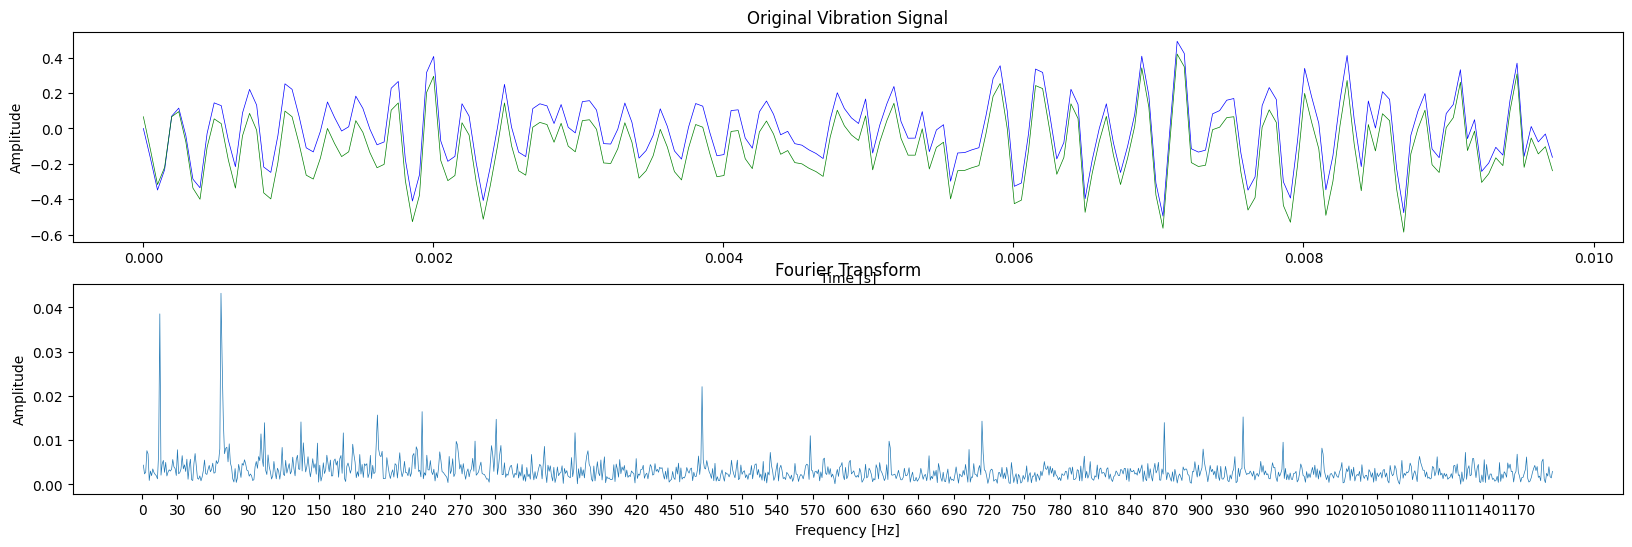

Timestamp('2003-11-25 23:29:00')

In [ ]:
test = 1
bearing = 7   # Roller element failure 2500
num = 2154
image = to_fft3(tests[test-1][bearing -1][0].iloc[num,:], 20480)
image.show()
tests[test-1][bearing -1][0].iloc[num,:].name

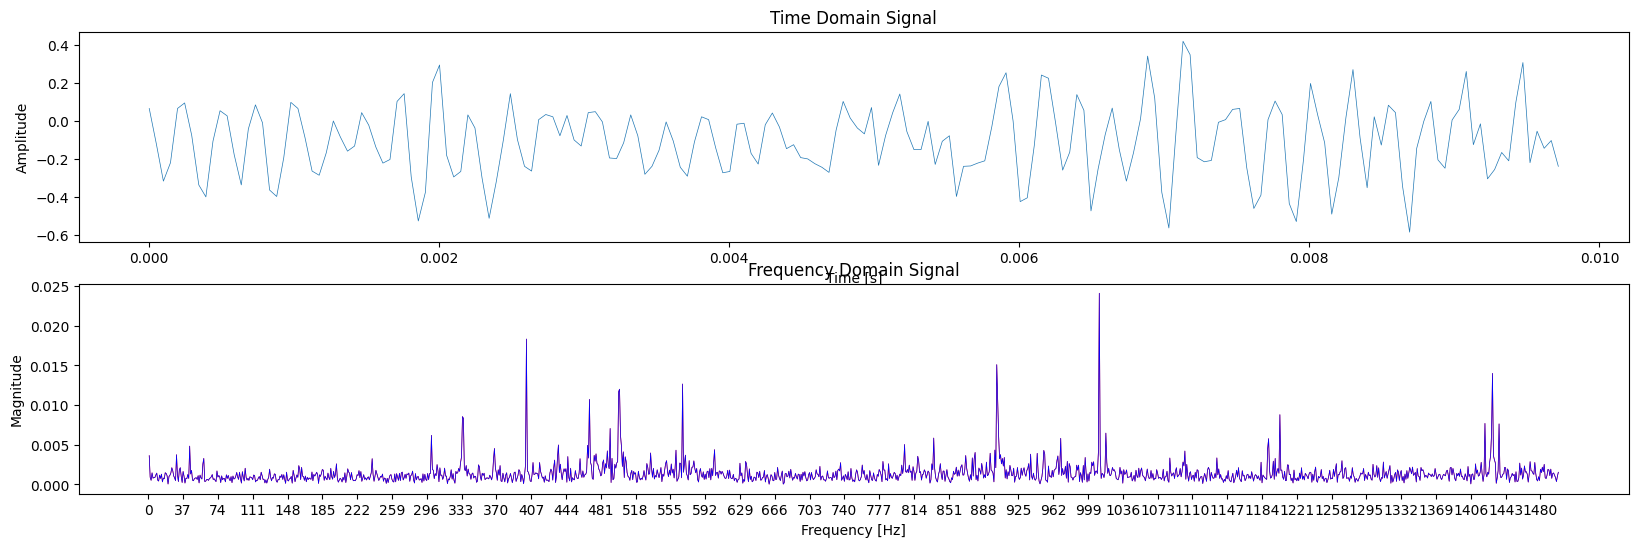

Timestamp('2003-11-25 23:29:00')

In [ ]:
test = 1
bearing = 7   # Roller element failure
num = 2154
image = to_fft2(tests[test-1][bearing -1][0].iloc[num,:], 20480)
image.show()
tests[test-1][bearing -1][0].iloc[num,:].name

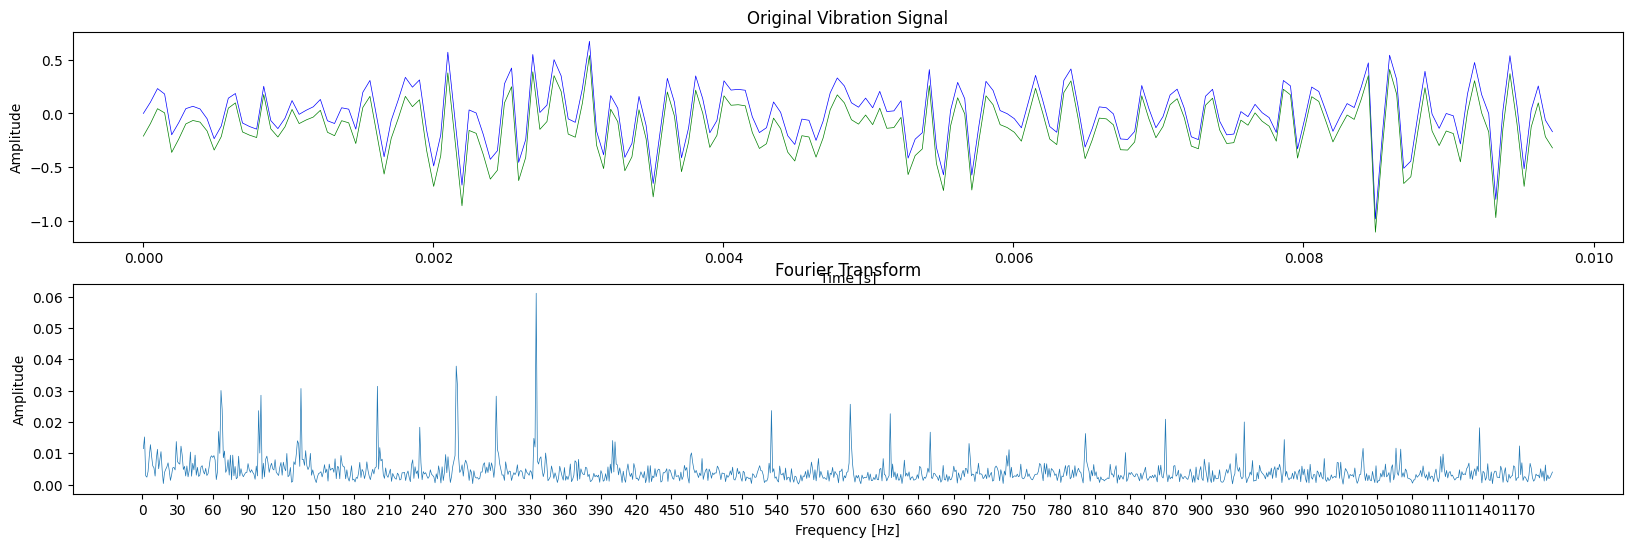

Timestamp('2003-11-25 15:57:00')

In [ ]:
test = 1
bearing = 5  # Inner race fault
num = 2150
image = to_fft3(tests[test-1][bearing -1][0].iloc[num,:], 20480)
image.show()
tests[test-1][bearing -1][0].iloc[num,:].name

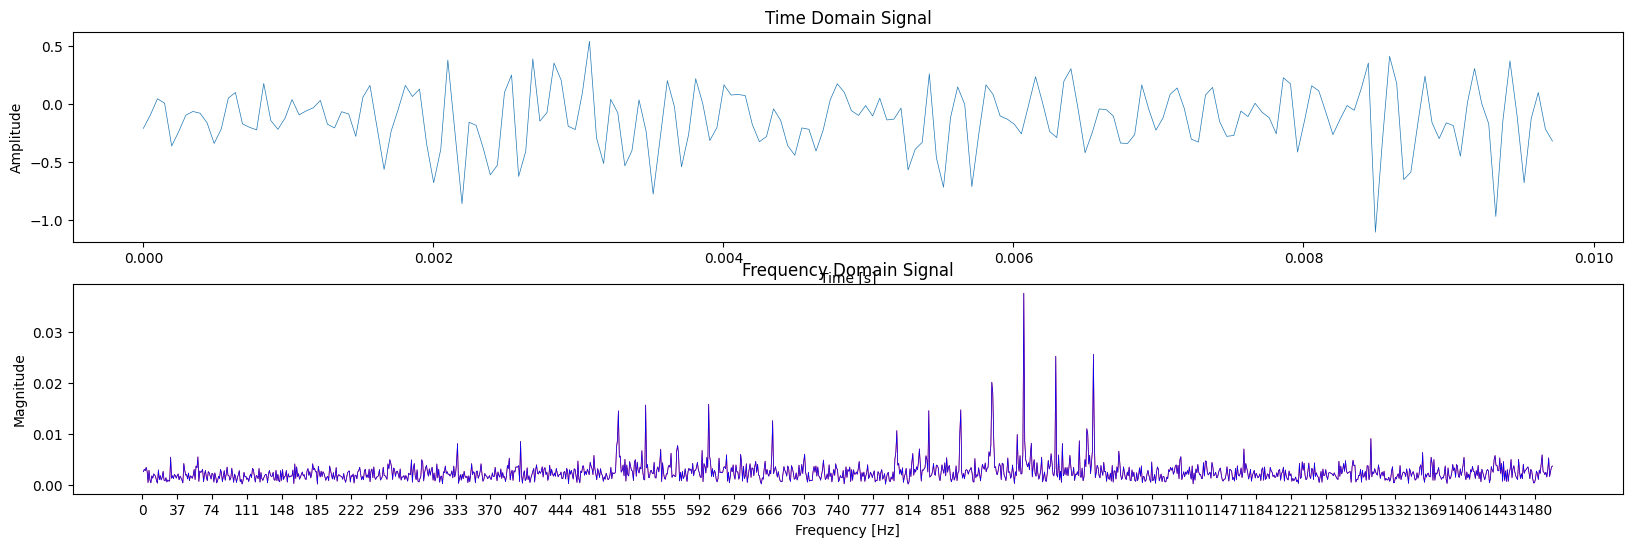

Timestamp('2003-11-25 15:57:00')

In [ ]:
test = 1
bearing = 5  # Inner race fault
num = 2150
image = to_fft2(tests[test-1][bearing -1][0].iloc[num,:], 20480)
image.show()
tests[test-1][bearing -1][0].iloc[num,:].name

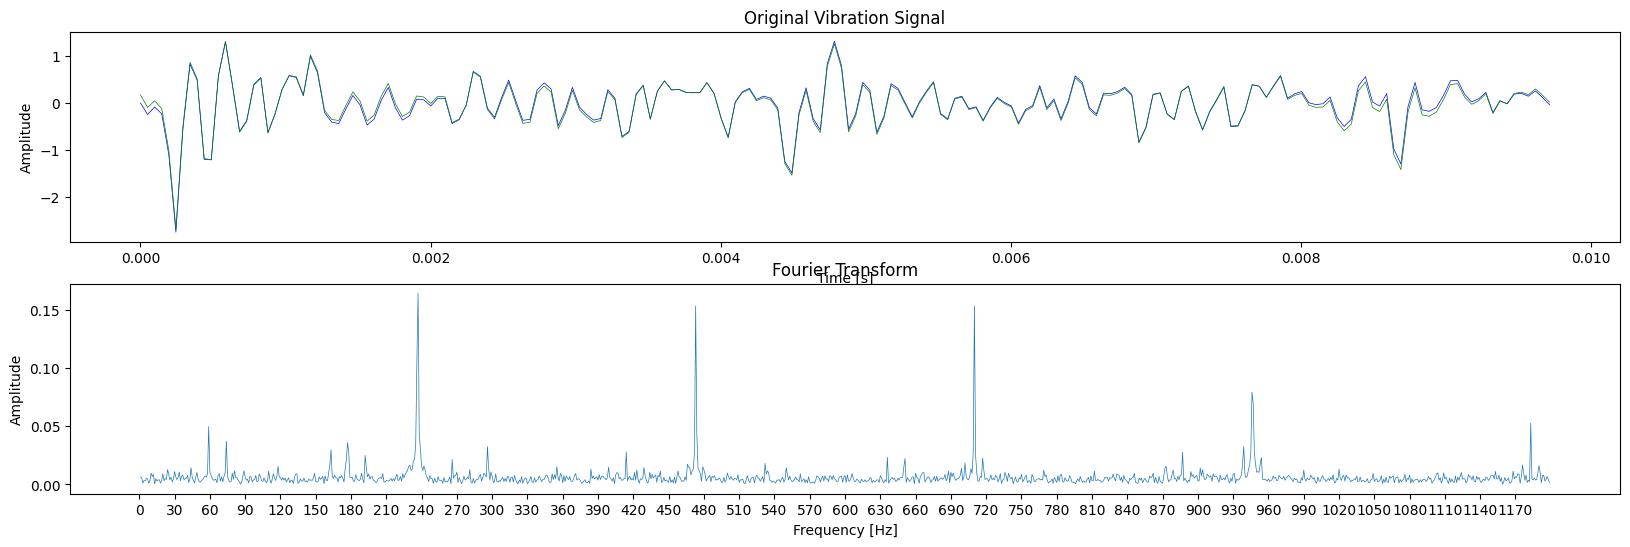

Timestamp('2004-02-19 05:52:00')

In [ ]:
test = 2
bearing = 1   # Outer race failure
num = 980
image = to_fft3(tests[test-1][bearing -1][0].iloc[num,:], 20480)
image.show()
tests[test-1][bearing -1][0].iloc[num,:].name

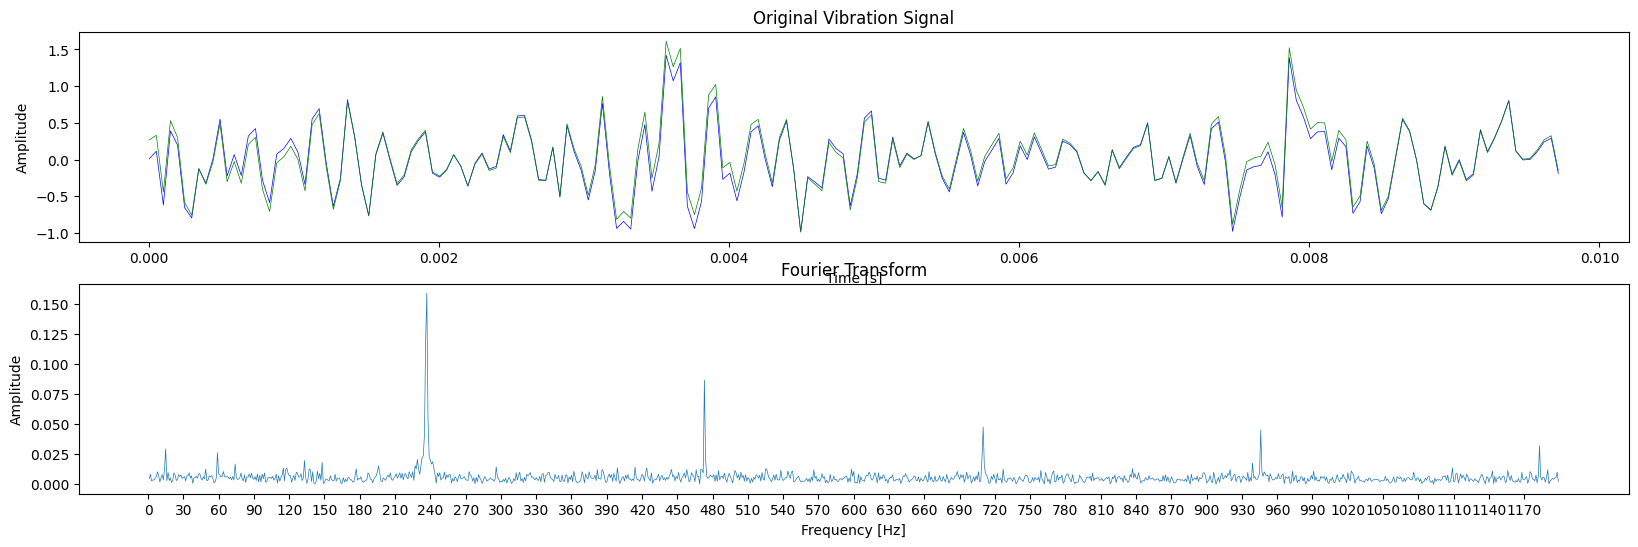

Timestamp('2004-04-18 02:12:00')

In [ ]:
test = 3
bearing = 3   # Outer race failure
num = 6320
image = to_fft3(tests[test-1][bearing -1][0].iloc[num,:], 20480)
image.show()
tests[test-1][bearing -1][0].iloc[num,:].name

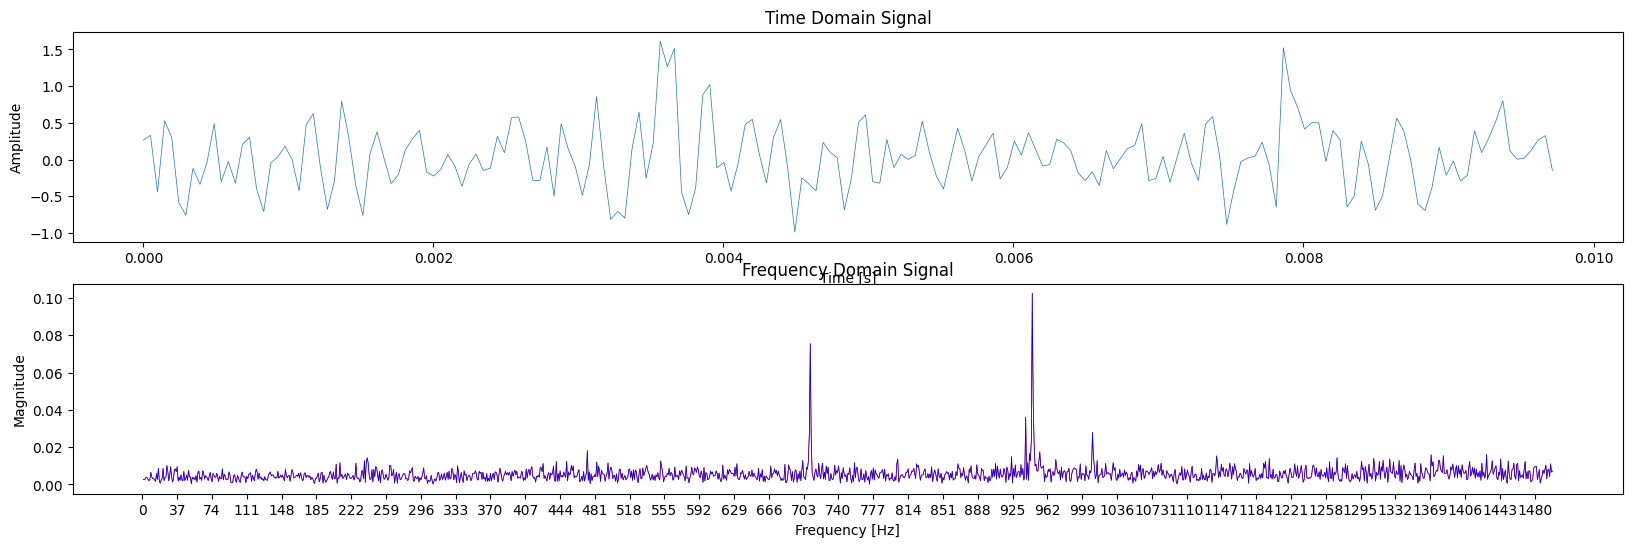

Timestamp('2004-04-18 02:12:00')

In [ ]:
test = 3
bearing = 3    # Outer race failure
num = 6320
image = to_fft2(tests[test-1][bearing -1][0].iloc[num,:], 20480)
image.show()
tests[test-1][bearing -1][0].iloc[num,:].name

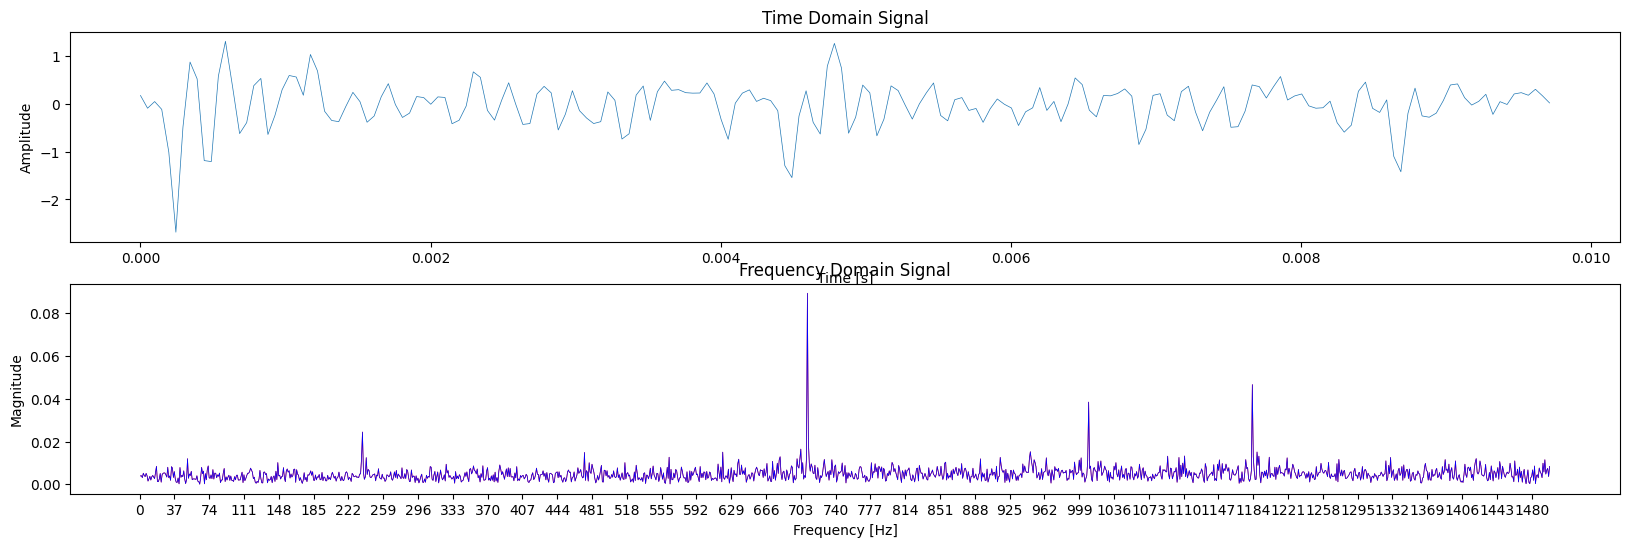

KeyError: 1

In [ ]:
test = 2
bearing = 1    # Outer race failure
num = 980
image = to_fft2(tests[test-1][bearing -1][0].iloc[num,:], 20480)
image.show()
tests[test-1][bearing -1][1].iloc[num,:].name

In [ ]:
# num = 0
# image = to_fft2(tests[test-1][bearing -1][0].loc['2004-02-12 10:32:00',:], 20480)
# # # print(tests[test-1][bearing -1][1].iloc[num,:].name)
# # image.savefig('nasa_bearing_dataset/images/prueba02.png')
# image.show()

In [ ]:
num = 1500
image = to_fft2(tests[test-1][bearing -1][0].iloc[num,:], 20480)
image.show()
tests[test-1][bearing -1][1].iloc[num,:].name

In [ ]:
num = 2100
to_fft2(tests[test-1][bearing -1][0].iloc[num,:], 20480)
tests[test-1][bearing -1][1].iloc[num,:].name

In [ ]:
num = 2155
to_fft2(tests[test-1][bearing -1][0].iloc[num,:], 20480)
tests[test-1][bearing -1][1].iloc[num,:].name

In [ ]:
tests[test-1][bearing -1][0].isna().sum().sum()

In [ ]:
tests[test-1][bearing -1][1].isna().sum().sum()

In [ ]:
tests[test-1][bearing -1][2].isna().sum().sum()

In [ ]:
tests[test-1][bearing -1][2].isna().sum()

In [ ]:
# df[0].loc['2004-02-12 10:32:00':'2004-02-16 03:42:00','fault'] = 'Normal'
# df[0].loc['2004-02-16 03:52:00':'2004-02-19 06:02:00','fault'] = 'Outer Race'
# df[0].to_csv(f'nasa_bearing_dataset/target_test{test}_bearing_{bearing}_time.csv')

In [ ]:
# df_f[0].loc['2004-02-12 10:32:00':'2004-02-16 03:42:00','fault'] = 'Normal'
# df_f[0].loc['2004-02-16 03:52:00':'2004-02-19 06:02:00','fault'] = 'Outer Race'
# df_f[0].to_csv(f'nasa_bearing_dataset/target_test{test}_bearing_{bearing}_feature.csv')

In [ ]:
# df_freq[0].loc['2004-02-12 10:32:00':'2004-02-16 03:42:00','fault'] = 'Normal'
# df_freq[0].loc['2004-02-16 03:52:00':'2004-02-19 06:02:00','fault'] = 'Outer Race'
# df_freq[0].to_csv(f'nasa_bearing_dataset/target_test{test}_bearing_{bearing}_freq.csv')